# 糖尿病预测数据预处理与建模（基于 BRFSS 数据集）

本 Notebook 包括以下模块：

- 数据划分与标准化  
- 类别分布检查与上采样  
- 标准化可视化  
- XGBoost 模型训练与评估  


In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import pandas as pd

# 机器学习
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, precision_recall_curve, roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 树模型
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier  # 需要单独安装：pip install lightgbm

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns

# 对数据进行预处理

In [98]:

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 1. 加载数据
df = pd.read_csv('data/CDC_BRFSS2015.csv')
df.columns = [
    'Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
    'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth',
    'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income'
]

# 2. 删除不合理的 BMI
df = df[df['BMI'].between(10, 60)]

# 3. 标签特征构造
df['IsObese'] = (df['BMI'] >= 30).astype(int)
df['HealthRiskScore'] = df['MentHlth'] + df['PhysHlth']
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 24.9, 29.9, 60],
                            labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 4, 9, 13], labels=['Youth', 'MiddleAge', 'Elder'])

# 4. 类别特征 One-Hot 编码（Sex、Education、Income、BMI_Category、AgeGroup）
df = pd.get_dummies(df, columns=['Sex', 'Education', 'Income', 'BMI_Category', 'AgeGroup'], drop_first=True)

# 5. 特征缩放：标准化连续变量
scaler = StandardScaler()
df[['BMI', 'HealthRiskScore', 'Age']] = scaler.fit_transform(df[['BMI', 'HealthRiskScore', 'Age']])

# 6. 目标与特征分离
X = df.drop(columns=['Diabetes_binary'])
y = df['Diabetes_binary']

# 7. 处理类别不平衡（SMOTE 过采样）
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 8. 合并输出处理结果
df_final = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='Diabetes_binary')], axis=1)
df_final.to_csv('aftprocessdata/processed_brfss.csv', index=False)
print("✅ 已生成增强后的处理数据：processed_brfss.csv")



✅ 已生成增强后的处理数据：processed_brfss.csv


# 加载数据（请确保已预处理为 processed_brfss.csv）

In [99]:

data = pd.read_csv('aftprocessdata/processed_brfss.csv')
data.head()
#类别数量检查
print("Class 0:", (data.iloc[:,-1] == 0).sum())
print("Class 1:", (data.iloc[:,-1] == 1).sum())


Class 0: 217700
Class 1: 217700


# 上采样函数定义与执行
复制少数类样本使其数量增加到与多数类相等，这样可以平衡训练数据的正负样本数量；


In [100]:
def oversample(df):
    if ((df.iloc[:,-1] == 0).sum()) >= ((df.iloc[:,-1] == 1).sum()):
        df_majority = df[df.iloc[:,-1] == 0]
        df_minority = df[df.iloc[:,-1] == 1]
    else:
        df_majority = df[df.iloc[:,-1] == 1]
        df_minority = df[df.iloc[:,-1] == 0]
    df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    return df_upsampled.sample(frac=1, random_state=0).reset_index(drop=True)

# 执行上采样
data_balanced = oversample(data)
data_balanced['Diabetes_binary'].value_counts()


Diabetes_binary
0.0    217700
1.0    217700
Name: count, dtype: int64

# 数据划分以及标准化

In [101]:
def data_split(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

def data_scaling(train_x, test_x):
    scaler = StandardScaler()
    train_x_scaled = scaler.fit_transform(train_x)
    test_x_scaled = scaler.transform(test_x)
    return train_x_scaled, test_x_scaled

# 执行划分与标准化
train_x, test_x, train_y, test_y = data_split(data_balanced)
train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


# 创建训练集，测试集，验证集

In [102]:
# 1. 读取数据
df = pd.read_csv('aftprocessdata/processed_brfss.csv')

# 2. 拆分特征和标签
X = df.drop(columns=['Diabetes_binary'])
y = df['Diabetes_binary']

# 3. 先划分为训练集（70%）和临时集（30%）
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 4. 临时集再划分为验证集和测试集（各15%）
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# 5. 只对训练集做上采样
train_df = pd.concat([X_train, y_train], axis=1)

df_majority = train_df[train_df['Diabetes_binary'] == 0]
df_minority = train_df[train_df['Diabetes_binary'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

train_upsampled = pd.concat([df_majority, df_minority_upsampled])
train_upsampled = train_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_upsampled = train_upsampled.drop(columns=['Diabetes_binary'])
y_train_upsampled = train_upsampled['Diabetes_binary']

# 6. 验证集欠采样，调整为正负类1:1比例
val_df = pd.concat([X_val.reset_index(drop=True), y_val.reset_index(drop=True)], axis=1)
val_majority = val_df[val_df['Diabetes_binary'] == 0]
val_minority = val_df[val_df['Diabetes_binary'] == 1]

val_minority_size = min(len(val_majority), len(val_minority))
val_majority_downsampled = resample(val_majority, replace=False, n_samples=val_minority_size, random_state=42)
val_minority_downsampled = val_minority.sample(n=val_minority_size, random_state=42)

val_balanced = pd.concat([val_majority_downsampled, val_minority_downsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

X_val_balanced = val_balanced.drop(columns=['Diabetes_binary'])
y_val_balanced = val_balanced['Diabetes_binary']

# 7. 测试集欠采样，调整为正负类1:1比例
test_df = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
test_majority = test_df[test_df['Diabetes_binary'] == 0]
test_minority = test_df[test_df['Diabetes_binary'] == 1]

test_minority_size = min(len(test_majority), len(test_minority))
test_majority_downsampled = resample(test_majority, replace=False, n_samples=test_minority_size, random_state=42)
test_minority_downsampled = test_minority.sample(n=test_minority_size, random_state=42)

test_balanced = pd.concat([test_majority_downsampled, test_minority_downsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

X_test_balanced = test_balanced.drop(columns=['Diabetes_binary'])
y_test_balanced = test_balanced['Diabetes_binary']

# 8. 输出样本数及类别分布，确认效果
print(f"训练集样本数（上采样后）：{len(X_train_upsampled)}")
print(train_upsampled['Diabetes_binary'].value_counts())

print(f"验证集样本数（欠采样后）：{len(X_val_balanced)}")
print(y_val_balanced.value_counts())

print(f"测试集样本数（欠采样后）：{len(X_test_balanced)}")
print(y_test_balanced.value_counts())

# 9. 保存处理后的数据
X_train_upsampled.to_csv("sign/X_train.csv", index=False)
y_train_upsampled.to_csv("sign/y_train.csv", index=False)

X_val_balanced.to_csv("sign/X_val.csv", index=False)
y_val_balanced.to_csv("sign/y_val.csv", index=False)

X_test_balanced.to_csv("sign/X_test.csv", index=False)
y_test_balanced.to_csv("sign/y_test.csv", index=False)

训练集样本数（上采样后）：304780
Diabetes_binary
0.0    152390
1.0    152390
Name: count, dtype: int64
验证集样本数（欠采样后）：65310
Diabetes_binary
1.0    32655
0.0    32655
Name: count, dtype: int64
测试集样本数（欠采样后）：65310
Diabetes_binary
1.0    32655
0.0    32655
Name: count, dtype: int64


In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve
import xgboost as xgb
from lightgbm import LGBMClassifier

# 1. 读数据
X_train = pd.read_csv("sign/X_train.csv")
y_train = pd.read_csv("sign/y_train.csv").values.ravel()
X_val = pd.read_csv("sign/X_val.csv")
y_val = pd.read_csv("sign/y_val.csv").values.ravel()
X_test = pd.read_csv("sign/X_test.csv")
y_test = pd.read_csv("sign/y_test.csv").values.ravel()

# 2. 初始化基模型
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_estimators=500,
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=3,
    reg_alpha=0.1,
    reg_lambda=1,
    eval_metric='auc'
)

lgb_model = LGBMClassifier(
    objective='binary',
    random_state=42,
    n_estimators=7000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=2,
    reg_alpha=0.1,
    reg_lambda=1
)

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# 3. 各模型分别训练
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
)

rf_model.fit(X_train, y_train)

# 4. 创建 Stacking 模型
stack_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('rf', rf_model)
    ],
    final_estimator=LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3
    ),
    cv=5,
    passthrough=True,
    n_jobs=-1
)
# 5. 拟合 Stacking 模型
stack_model.fit(X_train, y_train)

# 6. 预测测试集概率
y_proba = stack_model.predict_proba(X_test)[:, 1]

threshold = 0.55
y_pred = (y_proba >= threshold).astype(int)

# 8. 模型评估
print("\n✅ 测试集分类报告（Stacking）:")
print(classification_report(y_test, y_pred))
print("混淆矩阵:")
print(confusion_matrix(y_test, y_pred))
print("准确率:", accuracy_score(y_test, y_pred))



[0]	validation_0-auc:0.86653
[100]	validation_0-auc:0.92304
[200]	validation_0-auc:0.94945
[300]	validation_0-auc:0.95919
[400]	validation_0-auc:0.96310
[499]	validation_0-auc:0.96506
[LightGBM] [Info] Number of positive: 152390, number of negative: 152390
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4875
[LightGBM] [Info] Number of data points in the train set: 304780, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/Users/fengzhu/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


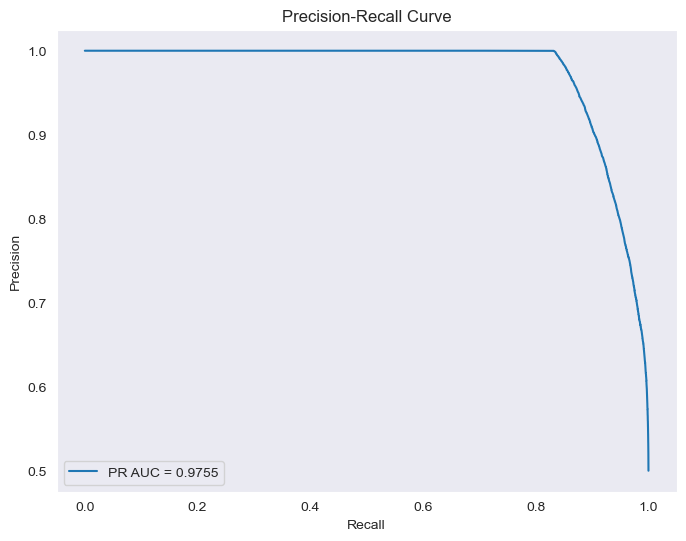

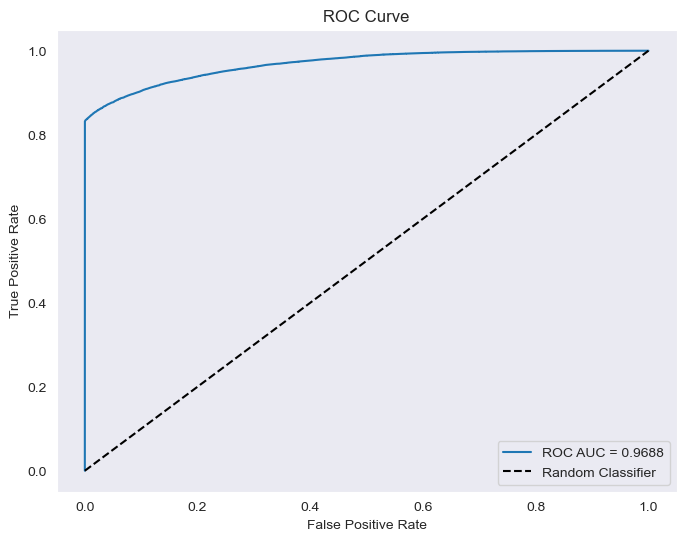

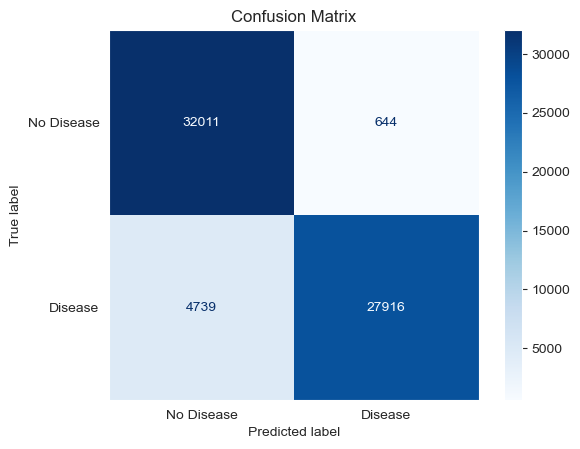

In [106]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, ConfusionMatrixDisplay

# Precision-Recall 曲线
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

# ROC 曲线
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# 混淆矩阵可视化
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Disease', 'Disease'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


